# Overview: Statistics on ambiguity (N1904-TF + N1904addons)

## Table of content (ToC)<a class="anchor" id="TOC"></a>
* <a href="#bullet1">1 - Introduction</a>
* <a href="#bullet2">2 - Load N1904-TF with the N1904addons</a>
* <a href="#bullet3">3 - Building the statistics</a>
    * <a href="#bullet3x1"> 3.1 - Word form to multiple SP tag (N1904-TF only)</a>
    * <a href="#bullet3x2"> 3.2 - Word form to multiple POS codes (N1904-TF only)</a> 
    * <a href="#bullet3x3"> 3.3 - Plot ambiguity in Morpheus-based dataset (N1904addons only)</a>
    * <a href="#bullet3x4"> 3.4 - Comparing N1904-TF and Morpheus tag diversity</a>
* <a href="#bullet4">4 - Attribution and footnotes</a>
* <a href="#bullet5">5 - Required libraries</a>
* <a href="#bullet6">6 - Notebook version</a>


#  1 - Introduction <a class="anchor" id="bullet1"></a>
##### [Back to ToC](#TOC)

This Jupyter Notebook a number of statistics are generated to quantify the morphological ambiguity in both the N1904_TF and the N1904addons dataset.

Ambiguity is defined here as any single word form that is assigned more than one morphological tag anywhere in the dataset. 

# 2 -  Load N1904-TF with the N1904addons <a class="anchor" id="bullet2"></a>
##### [Back to ToC](#TOC)

For this use case we do need both the base N1904-TF dataset with the Morpheus based extention N1904addons.

In [2]:
# Load the autoreload extension to automatically reload modules before executing code
%load_ext autoreload
%autoreload 2

In [3]:
# Loading the Text-Fabric code
from tf.fabric import Fabric
from tf.app import use

In [7]:
# Load the N1904-TF app and data with the additional features
A = use ("CenterBLC/N1904", mod=["tonyjurg/N1904addons/tf/", "tonyjurg/N1904addons/detailed_set"], silence="terse", hoist=globals())

**Locating corpus resources ...**

Name,# of nodes,# slots / node,% coverage
book,27,5102.93,100
chapter,260,529.92,100
verse,7944,17.34,100
sentence,8011,17.20,100
group,8945,7.01,46
clause,42506,8.36,258
wg,106868,6.88,533
phrase,69007,1.90,95
subphrase,116178,1.60,135
word,137779,1.00,100


Display is setup for viewtype [syntax-view](https://github.com/saulocantanhede/tfgreek2/blob/main/docs/syntax-view.md#start)

See [here](https://github.com/saulocantanhede/tfgreek2/blob/main/docs/viewtypes.md#start) for more information on viewtypes

In [5]:
# The following will push the Text-Fabric stylesheet to this notebook (to facilitate proper display with notebook viewer)
A.dh(A.getCss())

# 3 - Building the statistics <a class="anchor" id="bullet3"></a>
##### [Back to ToC](#TOC)

We will first examine ambiguity in the N1904-TF dataset.

## 3.1 - Word form to multiple SP tag (N1904-TF only)  <a class="anchor" id="bullet3x1"></a>

The following script dentifies all surface word forms that appear with two or more different morphological analyses. We then sort those “ambiguous” forms by the number of distinct tags they carry. This code snippet therefor builds two mappings: one from each surface form to its observed set of morphological tags, and another counting how often each form occurs. This way it computes both type‐level and token‐level ambiguity. After iterating over every word node, it filters out forms with two or more tags, calculates overall proportions of ambiguous forms and tokens, and finally prints those summaries along with the top N most ambiguous forms by tag count (including their token frequencies)

In [35]:
from collections import Counter  # import Counter to tally token frequencies

# 1. Retrieve every word‐node ID in the corpus
all_words = F.otype.s("word")  # F.otype.s("word") gives a list of all “word” objects

# 2. Initialize data structures:
form2tags   = {}               # this will map each surface form → set of observed morph tags
form_counts = Counter()        # this will count total occurrences of each surface form

# 3. Populate mappings by iterating over each word‐node
for w in all_words:
    form = F.text.v(w)         # extract the surface level word form (including accents)
    tag  = F.morph.v(w)        # extract its morphological annotation (e.g. "V-2AAI-3S")

    # a) Record the tag in the set for this form
    #    setdefault creates a new empty set if the word form is not seen before
    form2tags.setdefault(form, set()).add(tag)

    # b) Increment the token count for this word form
    form_counts[form] += 1

# 4. Identify (filter) ambiguous forms: those with ≥2 distinct morphological tags
ambiguous_forms = {
    form: tags
    for form, tags in form2tags.items()
    if len(tags) > 1          # keep only if more than one tag observed
}

# 5. Type‐based ambiguity summary (counts of forms)
total_forms      = len(form2tags)                  # the total unique word forms in the corpus
ambig_form_count = len(ambiguous_forms)            # how many of those have 2 or more tags
ambig_form_ratio = ambig_form_count / total_forms  # calculate proportion of word forms that map to different morph tags

# 6. Token‐based ambiguity summary (counts of tokens)
total_tokens      = sum(form_counts.values())       # total tokens in the corpus
ambig_token_count = sum(form_counts[f] for f in ambiguous_forms)  
# sum counts of all tokens whose form is ambiguous

ambig_token_ratio = ambig_token_count / total_tokens  # proportion of tokens that are ambiguous

# 7. Print out the computed summaries
print(f"Total distinct surface forms:       {total_forms}")
print(f"Forms with ≥2 different morph tags: {ambig_form_count}")
print(f"Proportion ambiguous:               {ambig_form_ratio:.2%}\n")

print(f"Total tokens in corpus:                  {total_tokens}")
print(f"Tokens in ambiguous forms:               {ambig_token_count}")
print(f"Percent of tokens that are ambiguous:    {ambig_token_ratio:.2%}\n")

# 8. Prepare to list the top‐N most ambiguous forms by tag‐count
top_n = 10  # change this to display more or fewer entries
sorted_by_tags = sorted(
    ambiguous_forms.items(),          # items() gives (form, set_of_tags)
    key=lambda item: len(item[1]),    # sort by size of tag‐set
    reverse=True                      # descending order → most ambiguous first
)

# 9. Print the top‐N forms with their tag‐counts and token‐counts
print(f"Top {top_n} most ambiguous forms (by # of distinct tags):")
for form, tags in sorted_by_tags[:top_n]:
    tag_count   = len(tags)            # number of different morph tags
    token_count = form_counts[form]    # how many times the form occurs
    
    # display the form, counts, and sorted list of its tags
    print(f"  {form!r}: {tag_count} tags; {token_count} occurrences → {sorted(tags)}")

Total distinct surface forms:       19446
Forms with ≥2 different morph tags: 874
Proportion ambiguous:               4.49%

Total tokens in corpus:                  137779
Tokens in ambiguous forms:               23919
Percent of tokens that are ambiguous:    17.36%

Top 10 most ambiguous forms (by # of distinct tags):
  'ἑαυτῶν': 5 tags; 43 occurrences → ['F-1GPM', 'F-2GPM', 'F-3GPF', 'F-3GPM', 'F-3GPN']
  'πρῶτον': 4 tags; 63 occurrences → ['A-ASM-S', 'A-ASN-S', 'A-NSN-S', 'ADV-S']
  'τρεῖς': 4 tags; 41 occurrences → ['A-APF', 'A-APM', 'A-NPF', 'A-NPM']
  'αἰώνιον': 4 tags; 45 occurrences → ['A-ASF', 'A-ASM', 'A-ASN', 'A-NSN']
  'ὀλίγον': 4 tags; 13 occurrences → ['A-ASM', 'A-ASN', 'A-NSN', 'ADV']
  'τινα': 4 tags; 32 occurrences → ['X-APN', 'X-ASF', 'X-ASM', 'X-NPN']
  'τρίτον': 4 tags; 24 occurrences → ['A-ASM', 'A-ASN', 'A-NSN', 'ADV']
  'Ἰησοῦ': 3 tags; 326 occurrences → ['N-DSM', 'N-GSM', 'N-VSM']
  'αὐτοῦ': 3 tags; 1411 occurrences → ['ADV', 'P-GSM', 'P-GSN']
  'τῶν': 3 tags; 

## 3.2 - Word form to multiple POS codes (N1904-TF only)  <a class="anchor" id="bullet3x2"></a>

Now we are going to check cases where there are multiple Part of Speech codes for the same word form. This is done by sorting the previously identified ambiguous word forms (stored in `ambiguous_forms`) by the number of distinct part-of-speech codes they exhibit (extracted as the segment before the first dash in each morph tag).

In [37]:
# This script takes `ambiguous` (form → set of tags) and `form_counts` (form → token count) from the previous codeblock

# 1. Build a mapping from form → set of POS indicators
#    (e.g. from "V-2AAI-3S" we extract "V")
form2pos = {
    form: {tag.split("-", 1)[0] for tag in tags}
    for form, tags in ambiguous_forms.items()
}

# 2. Sort forms by descending number of distinct POS values
#    yields a list of (form, pos_set) tuples
sorted_by_pos = sorted(
    form2pos.items(),
    key=lambda item: len(item[1]),  # sort by how many POS each form has
    reverse=True                     # largest first
)

# 3. Inspect the top N, including number of occurrences
top_n = 10
print(f"Top {top_n} forms by number of distinct POS indicators:")
for form, pos_set in sorted_by_pos[:top_n]:
    pos_count   = len(pos_set)         # how many different POS tags
    occ_count   = form_counts[form]    # total times this form appears
    # display form, POS‐count, token‐count, and the sorted list of POS
    print(
        f"  {form!r}: "
        f"{pos_count} POS; "
        f"{occ_count} occurrences → "
        f"{sorted(pos_set)}"
    )

Top 10 forms by number of distinct POS indicators:
  'αὐτοῦ': 2 POS; 1411 occurrences → ['ADV', 'P']
  'ὅ': 2 POS; 46 occurrences → ['R', 'T']
  'οὗ': 2 POS; 139 occurrences → ['ADV', 'R']
  'Ἰουδαίας': 2 POS; 27 occurrences → ['A', 'N']
  'τίς': 2 POS; 116 occurrences → ['I', 'X']
  'ποτε': 2 POS; 46 occurrences → ['ADV', 'PRT']
  'ἐμοῦ': 2 POS; 114 occurrences → ['P', 'S']
  'ἔμπροσθεν': 2 POS; 40 occurrences → ['ADV', 'PREP']
  'πρῶτον': 2 POS; 63 occurrences → ['A', 'ADV']
  'ποτέ': 2 POS; 5 occurrences → ['ADV', 'PRT']


## 3.3 - Plot ambiguity in Morpheus-based dataset (N1904addons only) <a class="anchor" id="bullet3x3"></a>

This snippet first determines the counts of how many morphological blocks each token has (including tokens with zero blocks). This can be easily done by means of obtaining the frequency list for feature `mm_num_blocks` by means of `F.mm_num_blocks.freqList()`. Since this does not count empty values, a simple query can be used to determine its amount: `A.search('word mm_num_blocks#')`. This is then organizes into a pandas Series keyed by block‐count, and then renders a bar chart showing the full distribution of block counts across the N1904-TF dataset.

In [38]:
F.mm_num_blocks.freqList()

((1, 54069),
 (2, 28418),
 (3, 19777),
 (4, 12157),
 (5, 9515),
 (6, 3898),
 (7, 2701),
 (8, 1687),
 (9, 922),
 (10, 811),
 (12, 604),
 (11, 365),
 (13, 207),
 (15, 118),
 (14, 102),
 (17, 92),
 (20, 78),
 (16, 35),
 (21, 28),
 (23, 25),
 (18, 19),
 (25, 17),
 (19, 9),
 (22, 1))

In [39]:
len(A.search('word mm_num_blocks#',silent='silent'))

2124

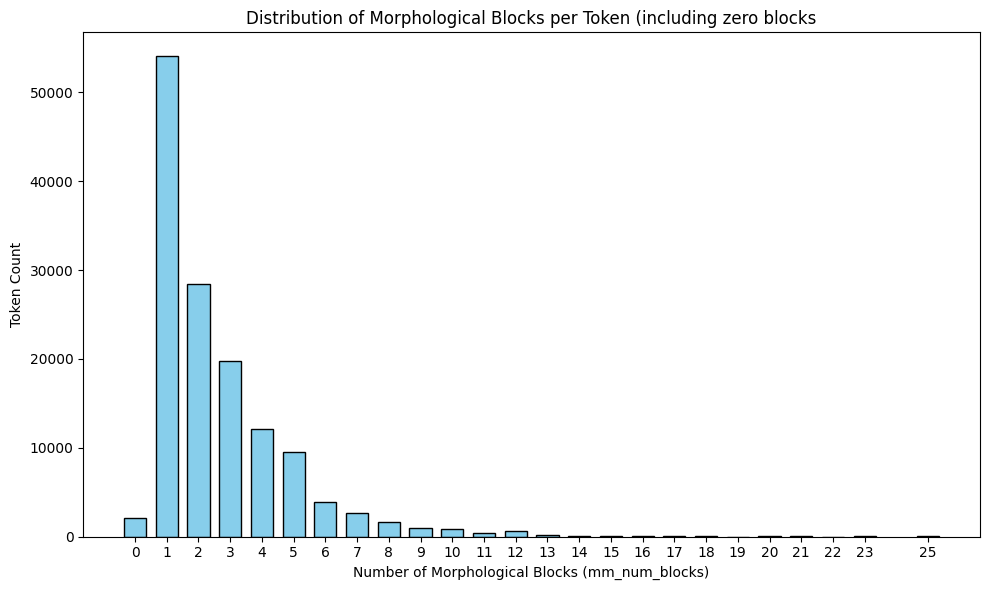

In [40]:
import matplotlib.pyplot as plt
import pandas as pd

# 1. Get the frequency list for tokens that have one or more analytic blocks
#    each tuple is (n_blocks, token_count)
mm_freq_list = F.mm_num_blocks.freqList()

# 2. Count tokens that have zero blocks by searching for the missing feature
zero_blocks_count = len(A.search('word mm_num_blocks#', silent='silent'))

# 3. Build a dict mapping block-counts → token counts, and insert the zero-block case
block_counts = {n: cnt for n, cnt in mm_freq_list}
block_counts[0] = zero_blocks_count

# 4. Create a pandas Series, sorted by block-count
mm_counts = pd.Series(block_counts).sort_index()

# 5. Plot as a bar chart, one bar per integer (including 0)
plt.figure(figsize=(10, 6))
plt.bar(
    mm_counts.index,     # x: number of blocks (0, 1, 2, …)
    mm_counts.values,    # y: how many tokens have that many blocks
    width=0.7,           # narrower than 1 so bars are separated
    edgecolor='black',   # outline each bar
    color='skyblue'      # fill color
)

# 6. Annotate the chart
plt.xticks(mm_counts.index)  
plt.xlabel("Number of Morphological Blocks (mm_num_blocks)")
plt.ylabel("Token Count")
plt.title("Distribution of Morphological Blocks per Token (including zero blocks")
plt.tight_layout()
plt.show()


In [41]:
# The following uses `mm_counts` already computed in the previous codeblock
# Compute the average number of blocks per token
total_tokens = mm_counts.sum()
average_blocks = (mm_counts.index.to_numpy() * mm_counts.values).sum() / total_tokens
print(f"Average number of analytic blocks per token: {average_blocks:.2f}")

Average number of analytic blocks per token: 2.62


## 3.4 - Comparing N1904-TF and Morpheus tag diversity <a class="anchor" id="bullet3x4"></a>

This snippet compares tag diversity for ten target tokens by pulling each token’s distinct N1904 TF tags and then merging in all Morpheus analyses. It builds a small results list recording both tag counts and the full Morpheus tag set, and finally prints a compact table showing, per token, how many tags N1904 has, how many Morpheus provides, and exactly which Morpheus tags appear.

In [48]:
import pandas as pd

# -----------------------------------------------------------------------------
# Inspect and compare N1904 vs. Morpheus morphological tag diversity for select tokens (i.e the top 10 from N1904-TF)
# amb_df holds columns: 'token', 'morph' (N1904 primary tag), 'alt_morphs' (Morpheus variants)
# -----------------------------------------------------------------------------

# 1. Define the list of target tokens to analyze
targets = [
    'ἑαυτῶν', 'πρῶτον', 'τρεῖς', 'αἰώνιον', 'ὀλίγον', 'τινα', 'τρίτον', 'Ἰησοῦ', 'αὐτοῦ', 'τῶν'
]

# 2. Container for results
results = []

# 3. Loop over each token
for tok in targets:
    # 3a. Subset DataFrame to rows matching this token
    df_tok = amb_df[amb_df['token'] == tok]

    # 3b. N1904 (TF) tag set: distinct primary morph tags across occurrences
    tf_tags = set(df_tok['morph'])

    # 3c. Morpheus tag set: start with TF tags, then add all alt_morphs
    mor_tags = set(tf_tags)
    for alt_list in df_tok['alt_morphs']:
        mor_tags.update(alt_list)

    # 3d. Record token, N1904 count, Morpheus count, and sorted Morpheus tag list
    results.append({
        'token':                tok,
        'n1904_tag_count':       len(tf_tags),      # distinct TF morph tags
        'morpheus_tag_count':    len(mor_tags),     # distinct Morpheus analyses
        'morpheus_tags':         sorted(mor_tags)   # list of Morpheus tags
    })

# 4. Print a formatted comparison table
print(f"{'token':<10} {'N1904#':>7} {'Morph#':>7}   Morpheus tags")
print("-" * 60)
for r in results:
    print(f"{r['token']:<10} {r['n1904_tag_count']:>7} {r['morpheus_tag_count']:>7}   {r['morpheus_tags']}")


token       N1904#  Morph#   Morpheus tags
------------------------------------------------------------
ἑαυτῶν           5       8   ['F-1GPM', 'F-2GPM', 'F-3GPF', 'F-3GPM', 'F-3GPN', 'P-GPF', 'P-GPM', 'P-GPN']
πρῶτον           4       8   ['A-ASM-S', 'A-ASN-S', 'A-NSN-S', 'ADV-S', 'N-ASM', 'N-ASN', 'N-NSN', 'N-VSN']
τρεῖς            4       7   ['A-APF', 'A-APM', 'A-NPF', 'A-NPM', 'A-NUI', 'V-IAI-2S-ATT', 'V-PAI-2S-ATT']
αἰώνιον          4       9   ['A-ASF', 'A-ASM', 'A-ASN', 'A-NSN', 'N-ASF', 'N-ASM', 'N-ASN', 'N-NSN', 'N-VSN']
ὀλίγον           4       8   ['A-ASM', 'A-ASN', 'A-NSN', 'ADV', 'N-ASM', 'N-ASN', 'N-NSN', 'N-VSN']
τινα             4       6   ['N-PRI', 'X-APN', 'X-ASF', 'X-ASM', 'X-NPN', 'X-VPN']
τρίτον           4       8   ['A-ASM', 'A-ASN', 'A-NSN', 'ADV', 'N-ASM', 'N-ASN', 'N-NSN', 'N-VSN']
Ἰησοῦ            3       6   ['N-DSM', 'N-GSM', 'N-GSM-ATT', 'N-PRI', 'N-VSM', 'N-VSM-ATT']
αὐτοῦ            3       3   ['ADV', 'P-GSM', 'P-GSN']
τῶν              3       3   ['T

# 4 - Attribution and footnotes <a class="anchor" id="bullet4"></a>
##### [Back to ToC](#TOC)

Greek base text: Nestle1904 Greek New Testament, edited by Eberhard Nestle, published in 1904 by the British and Foreign Bible Society. Transcription by [Diego Santos](https://sites.google.com/site/nestle1904/home). Public domain.

The [N1904-TF dataset](https://centerblc.github.io/N1904/) is available under the [MIT licence](https://github.com/CenterBLC/N1904/blob/main/LICENSE.md). Formal reference: 
> Tony Jurg, Saulo de Oliveira Cantanhêde, & Oliver Glanz. (2024). *CenterBLC/N1904: Nestle 1904 Text-Fabric data*. Zenodo. DOI: [10.5281/zenodo.13117911](https://doi.org/10.5281/zenodo.13117910).

This notebook is released under the [Creative Commons Attribution 4.0 International (CC BY 4.0)](https://github.com/tonyjurg/Create-TF-entropy-features/blob/main/LICENSE.md).

# 5 - Required libraries<a class="anchor" id="bullet5"></a>
##### [Back to ToC](#TOC)

Since the scripts in this notebook utilize Text-Fabric, [it requires currently (Apr 2025) Python >=3.9.0](https://pypi.org/project/text-fabric) together with the following libraries installed in the environment: 

    collections
    matplotlib
    pandas
    
You can install any missing library from within Jupyter Notebook using either`pip` or `pip3`.

# 6 - Notebook version<a class="anchor" id="bullet6"></a>
##### [Back to ToC](#TOC)

<div style="float: left;">
  <table>
    <tr>
      <td><strong>Author</strong></td>
      <td>Tony Jurg</td>
    </tr>
    <tr>
      <td><strong>Version</strong></td>
      <td>1.2</td>
    </tr>
    <tr>
      <td><strong>Date</strong></td>
      <td>23 July 2025</td>
    </tr>
  </table>
</div>